In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('Working on CUDA...')
else:
  device = 'cpu'
  print('Working on CPU...')

Working on CPU...


In [ ]:
batch_size = 32
num_workers = 0
valid_size = 0.2

data_transform = transforms.Compose([#transforms.RandomResizedCrop(224),
                                     transforms.RandomAffine(30),
                                     transforms.RandomHorizontalFlip(0.5),
                                     transforms.RandomRotation(30),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=data_transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=data_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

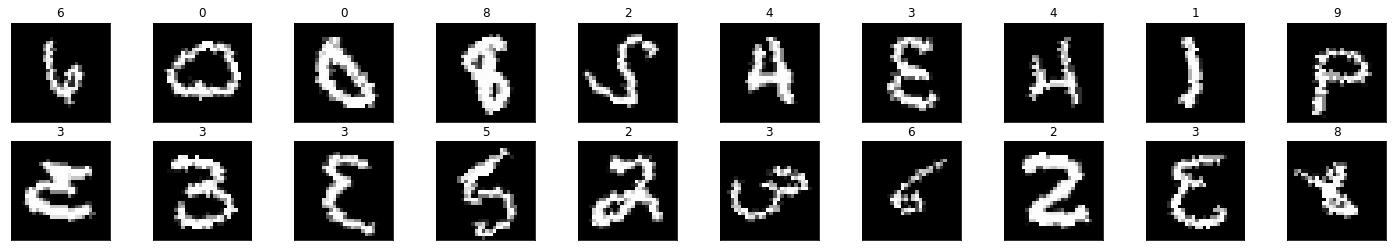

In [ ]:
# Display images

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(str(labels[idx].item()))

In [ ]:
# The LeNet architecture model

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # Input shape --> : 28 * 28 * 1
    self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
    # Shape --> 28 * 28 * 16 - MaxPool reduces x-y dimensions by a factor of 2 here. And no. of channels increases from 1 to 16
    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1) # Shape --> 14 * 14 * 16
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(7 * 7 * 32, 512)
    self.fc2 = nn.Linear(512, 10)

  def forward(self, x):  # Input shape: 28 * 28 * 1
    x = self.pool(F.relu(self.conv1(x)))  # 14 * 14 * 16
    x = self.pool(F.relu(self.conv2(x)))  # 7 * 7 * 32
    x = x.view(-1, 7 * 7 * 32)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=1)

    return x

model = LeNet()
print(model)

if device == 'cuda':
  model.cuda()

LeNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20
train_losses = []
valid_losses = []
valid_accuracies = []

valid_loss_min = np.Inf

for e in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0

  for images, labels in train_loader:
    if device == 'cuda':
      images, labels = images.cuda(), labels.cuda()

    optimizer.zero_grad()
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  model.eval()
  accuracy = 0
  for images, labels in validation_loader:
    if device == 'cuda':
      images, labels = images.cuda(), labels.cuda()

    logps = model(images)
    loss = criterion(logps, labels)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    valid_loss += loss.item()

  train_loss = train_loss / len(train_loader)
  valid_loss = valid_loss / len(validation_loader)
  accuracy = accuracy / len(validation_loader)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  valid_accuracies.append(accuracy)

  print('Epoch {}'.format(e+1),
        'Training Loss: {:.3f}'.format(train_loss),
        'Validation Loss: {:.3f}'.format(valid_loss),
        'Validation accuracy: {:.3f}'.format(accuracy))
  
  if valid_loss <= valid_loss_min:
    print('Validation Loss decreased: {:.6f} --> {:.6f}. Saving Model...'.format(
          valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_cifar10.pt')
    valid_loss_min = valid_loss

Epoch 1 Training Loss: 1.682 Validation Loss: 1.573 Validation accuracy: 0.890
Validation Loss decreased: inf --> 1.572935. Saving Model...
Epoch 2 Training Loss: 1.551 Validation Loss: 1.538 Validation accuracy: 0.924
Validation Loss decreased: 1.572935 --> 1.537771. Saving Model...
Epoch 3 Training Loss: 1.532 Validation Loss: 1.544 Validation accuracy: 0.918
Epoch 4 Training Loss: 1.524 Validation Loss: 1.522 Validation accuracy: 0.940
Validation Loss decreased: 1.537771 --> 1.521914. Saving Model...
Epoch 5 Training Loss: 1.520 Validation Loss: 1.517 Validation accuracy: 0.944
Validation Loss decreased: 1.521914 --> 1.516766. Saving Model...
Epoch 6 Training Loss: 1.517 Validation Loss: 1.522 Validation accuracy: 0.939
Epoch 7 Training Loss: 1.514 Validation Loss: 1.519 Validation accuracy: 0.942
Epoch 8 Training Loss: 1.513 Validation Loss: 1.514 Validation accuracy: 0.948
Validation Loss decreased: 1.516766 --> 1.513614. Saving Model...
Epoch 9 Training Loss: 1.510 Validation Los

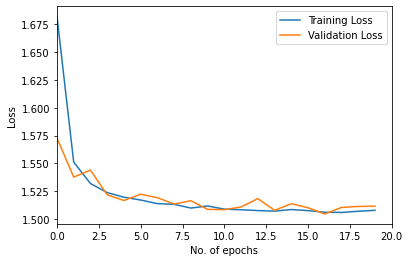

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

plt.xlim([0, 20])

plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model.load_state_dict(torch.load('model_cifar10.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
test_accuracy = 0.0

model.eval()
for images, labels in test_loader:
  if device == 'cuda':
    images, labels = images.cuda(), labels.cuda()

  logps = model.forward(images)
  loss = criterion(logps, labels)
  test_loss += loss.item()

  ps = torch.exp(logps)
  top_p, top_class = ps.topk(1, dim=1)
  equals = top_class == labels.view(*top_class.shape)
  test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

test_accuracy = test_accuracy / len(test_loader)

print('Test accuracy: {}'.format(test_accuracy))
print('\n')
test_loss = test_loss / len(test_loader)
print('Test Loss: {}'.format(test_loss))

Test accuracy: 0.9568690095846646


Test Loss: 1.5041966019347073
